## InceptionV3 Transfer learning

---
<a id='step0'></a>
## Step 1: Import Datasets

In [66]:
%matplotlib inline

In [122]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile   


from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Activation
from keras import backend as K
from keras.callbacks import ModelCheckpoint  


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import SGD, RMSprop

In [123]:
print('Load data')

Load data


In [125]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 4)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('OCT2017-R2/train')
valid_files, valid_targets = load_dataset('OCT2017-R2/valid')

print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))



There are 1500 training images.
There are 900 validation images.


In [128]:
img_width, img_height = 150, 150
batch_size = 15
epochs = 15
train_data_dir = 'OCT2017-R2/train'
validation_data_dir = 'OCT2017-R2/valid'

In [129]:
print('Data Augmentation')

Data Augmentation


In [130]:
print('Preview Data Augmentation')

Preview Data Augmentation


In [131]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('OCT2017-R2/train/DME/DME-593275-6.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [132]:
print('First Model')

First Model


In [133]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential([
    
    #Locally connected layer containing fewer weights
    #Break the image up into smaller pieces
    #Use 75 filters to identify the most general patterns
    #Use standard kerner_size of 2
    Conv2D(filters=75, kernel_size=2, padding='same', activation='relu', input_shape=input_shape),
    
    #Reduce dimensionality of convolutional layer,
    #Reduce by taking the maximum value in the filter
    MaxPooling2D(pool_size=2),
    
    #Use 100 filters to identify the more specific patterns
    #Use standard kerner_size of 2
    Conv2D(filters=100, kernel_size=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    #Use 125 filters to identify the more specific patterns
    #Use standard kerner_size of 2
    Conv2D(filters=125, kernel_size=2, padding='same', activation='relu'),
    
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    # Add a softmax activation layer
    Dense(4, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [134]:
print('Prepare Data')

Prepare Data


In [135]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'OCT2017-R2/train',  # this is the target directory
        target_size=(img_width, img_height),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'OCT2017-R2/valid',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

Found 1500 images belonging to 4 classes.
Found 900 images belonging to 4 classes.


In [136]:
print('Train the model')

Train the model


In [137]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        verbose=3)
model.save_weights('first_try.h5')

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


In [138]:
print('Test the Model')

Test the Model


Max Accuracy: 0.561


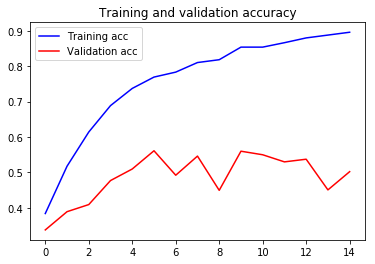

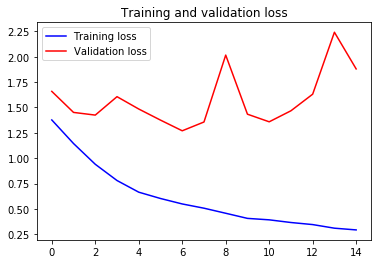

In [139]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
print('Max Accuracy: %1.3f' % max(val_acc))
    
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()


In [140]:
print('Make a prediction')

Make a prediction


In [141]:
print('VGG16')

VGG16


In [142]:
print('Save bottle neck features')

Save bottle neck features


In [143]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
model = VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = model.predict_generator(
    generator, len(train_files) // batch_size)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = model.predict_generator(
    generator, len(valid_files) // batch_size)

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)


print(len(bottleneck_features_train))
print(len(bottleneck_features_validation))

Found 1500 images belonging to 4 classes.
Found 900 images belonging to 4 classes.
1500
900


In [144]:
print('Train a small fully-connected model')

Train a small fully-connected model


In [151]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = train_targets

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = valid_targets

#print(len(train_data))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

model.save_weights(top_model_weights_path)

#print (train_data[0])
#print (train_labels[0])
#print (validation_data[0])
#print (validation_labels[0])

Train on 1500 samples, validate on 900 samples


TypeError: 'range' object cannot be interpreted as an integer